In [2]:
import pathlib
import pandas as pd
from lightgbm import LGBMRegressor, LGBMClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy import stats as st
from sklearn.pipeline import Pipeline
import phylolib as pll

from sklearn.base import BaseEstimator, TransformerMixin# define the transformer
class StandardMemoryScaler(BaseEstimator, TransformerMixin):

    def __init__(self, epsilon=1e-4):
        self._epsilon = epsilon
        
    def fit(self, X, y = None):
        self._mean = X.mean()
        self._std = X.std()
        return self

    def transform(self, X):
        X = (X-self._mean)/(self._std+self._epsilon)

        return X        

    def inverse_transform(self, X_scaled):
        X = X_scaled*(self._std+self._epsilon) + self._mean
        return X


In [3]:
REMOTE_PATH = "/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/"
DATASETS_PATH =  pathlib.Path(REMOTE_PATH) / "results"
CORRECTION_DATA_PATH = pathlib.Path(REMOTE_PATH) / "correction_data"
CORRECTION_DATA_PATH.resolve()
ALL_DATA_FILE = pathlib.Path("/home/elyalab/Data/correction/all_correction_data_v2.parquet.gzip")
LABEL_COLUMNS = [f"label_{i}" for i in range(0,27)]

In [4]:
def get_tree_features(tree_path: pathlib.Path):
    tree = pll.Tree(str(tree_path))
    sum_of_branches = tree.sum_of_branch_lengths()
    leaf_distances = tree.leaves_dist_from_root()
    max_distance, min_distance = max(leaf_distances), min(leaf_distances)
    num_leaves = tree.leaves_num()

    return sum_of_branches, min_distance, max_distance, num_leaves

In [5]:
somepath = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results_rerun/eggnog/Bacillus_1ZARG/RAxML_tree.tree")

In [6]:
get_tree_features(somepath)

(8.971457898899995, 0.20228059999999998, 0.429873, 75)

In [7]:
def fetch_paths(current_path: pathlib.Path):
    print(str(current_path))
    if len( n := list(current_path.glob("*.tree"))) == 1:
        tree_path = n[0]

    if len( n := list(current_path.glob("*.fasta"))) == 1:
        msa_path = n[0]

    if tree_path is None or msa_path is None:
        print("no fasta or tree file")
        exit()
    return tree_path, msa_path


In [8]:
get_tree_features("/home/elyalab/Data/orthomam/ENSG00000004948_CALCR/ENSG00000004948_CALCR_NT.tree")

(7.336260499999964, 0.10654649999999999, 0.679726, 109)

In [23]:
def fetch_all_data_df_from_server() -> pd.DataFrame:
    feature_files  = sorted(list(CORRECTION_DATA_PATH.glob("*_true.parquet.gzip")))
    label_files  = sorted(list(CORRECTION_DATA_PATH.glob("*_realigned.parquet.gzip")))
    for feature_path,label_path in zip(feature_files, label_files):
        dataset_a = "_".join(feature_path.stem.split("_")[:4])
        dataset_b = "_".join(label_path.stem.split("_")[:4])
        assert dataset_a == dataset_b
        
    tree_features = ["sum_branch_length", "min_dist_root", "max_dist_root", "num_leaves"]
    data_attributes = ["dataset", "length_distribution", "indel_model"]


    feature_dfs = []
    for feature_path,label_path in zip(feature_files, label_files):
        feature_df_tmp = pd.read_parquet(feature_path)
        label_df_tmp = pd.read_parquet(label_path)
        feature_df_tmp[LABEL_COLUMNS] = label_df_tmp
        columns_copy = feature_df_tmp.columns.copy()
        dataset, lendist, indel_model, _ = feature_path.stem.rsplit("_", maxsplit=3)
        feature_df_tmp[data_attributes] = dataset, lendist, indel_model
        
        if (DATASETS_PATH / "eggnog" / dataset).exists():
            tmp_path = DATASETS_PATH / "eggnog" / dataset
            tree_path, _ = fetch_paths(tmp_path)
        elif (DATASETS_PATH / "yeast" / dataset).exists():
            tmp_path = DATASETS_PATH / "yeast" / dataset
            tree_path, _ = fetch_paths(tmp_path)
        else:
            print(dataset, "is a problem")
        print(tree_path)
        sum_branch_length, min_dist_root, max_dist_root, num_leaves = get_tree_features(tree_path)
        feature_df_tmp[tree_features] = sum_branch_length, min_dist_root, max_dist_root, num_leaves

        reordered_columns = tree_features + list(columns_copy) + data_attributes
        feature_df_tmp = feature_df_tmp[reordered_columns]
        feature_dfs.append(feature_df_tmp)
    final_feature_labels_df = pd.concat(feature_dfs)

    return final_feature_labels_df


In [9]:
if ALL_DATA_FILE.exists():
    final_feature_labels_df = pd.read_parquet(ALL_DATA_FILE)
else:
    final_feature_labels_df = fetch_all_data_df_from_server()
    final_feature_labels_df.to_parquet(ALL_DATA_FILE, compression="gzip")
len(final_feature_labels_df)

1449000

In [34]:
# separated_dataset = final_feature_labels_df.query("dataset == 'Bacillus_1ZARG'")
# final_feature_labels_df = final_feature_labels_df[final_feature_labels_df.dataset != "Bacillus_1ZARG"]

In [10]:
regressor = LGBMRegressor()
labels = final_feature_labels_df['label_19']
features = final_feature_labels_df.loc[:,:'31']
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    train_size=0.8)
regressor.fit(X_train, y_train)

LGBMRegressor()

In [11]:
predictions = regressor.predict(X_test)

In [12]:
st.pearsonr(predictions,y_test )
# pd.Series(rounded_pred).value_counts()
# pd.Series(labels).value_counts()

PearsonRResult(statistic=0.8778670277120643, pvalue=0.0)

(array([2.5327e+05, 2.9418e+04, 5.4490e+03, 1.0120e+03, 4.7400e+02,
        1.2500e+02, 2.8000e+01, 1.5000e+01, 6.0000e+00, 3.0000e+00]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

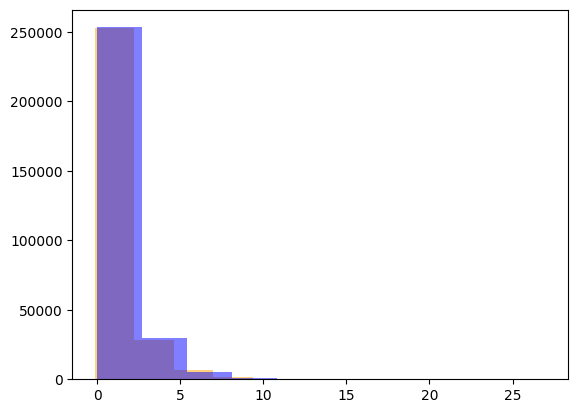

In [13]:
plt.hist(predictions, alpha=0.5, color="orange")
plt.hist(y_test, alpha=0.5, color="blue")

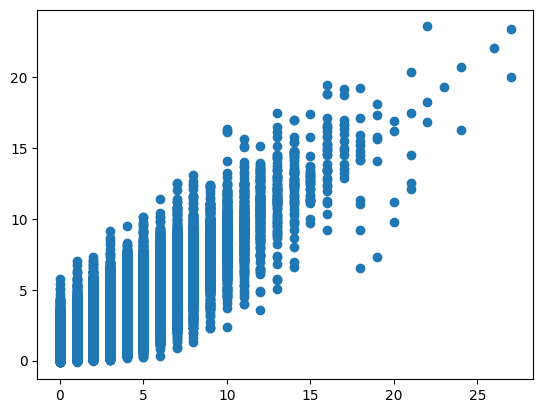

In [14]:
plt.scatter(y_test, predictions)

In [53]:
separated_dataset.loc[:,:'31']

NameError: name 'separated_dataset' is not defined

In [15]:
regressors = {}
bad_labels = []
for label in LABEL_COLUMNS:
    regressor = LGBMRegressor()
    # scaler = StandardMemoryScaler()
    regressors[label] = regressor#Pipeline(steps=[("scaler",scaler),("regressor", regressor)])
    labels = final_feature_labels_df[label]
    features = final_feature_labels_df.loc[:,:'31']
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        train_size=0.8)
    regressors[label].fit(X_train, y_train)

    predictions = regressors[label].predict(X_test)
    pearson_r = st.pearsonr(predictions, y_test)
    if pearson_r[0] < 0.9:
        bad_labels.append(label)
    print(f"correlation for {label} is: {pearson_r[0]:.3f}")

correlation for label_0 is: 0.945


KeyboardInterrupt: 

In [18]:
bad_labels = ['label_15', 'label_16', 'label_18', 'label_19']
bad_labels

['label_15', 'label_16', 'label_18', 'label_19']

In [16]:
selected_label = "label_19"
labels = final_feature_labels_df[selected_label]
prediction = regressors[selected_label].predict(final_feature_labels_df.loc[:,:'31'])
original_feature = final_feature_labels_df["24"]
# plt.scatter(labels, prediction)
plt.scatter(original_feature, prediction,
            marker='x', label="infered", c="blue")
plt.scatter(original_feature, labels,
            marker="P", label="realigned", c="orange")
plt.legend()


KeyError: 'label_19'

In [17]:
pd.Series(np.round(prediction)).value_counts()

NameError: name 'prediction' is not defined

In [19]:
regressors = {}
for label in bad_labels:
    labels = final_feature_labels_df[label]
    features = final_feature_labels_df.loc[:,:'31']
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        train_size=0.9)
    regressor = LGBMRegressor(num_leaves=36, n_estimators=10)
    regressor.fit(X_train, y_train)
    regressors[label] = regressor
    predictions = regressor.predict(X_test)
    # print(f"accuracy for {label} is: {accuracy_score(y_test, predictions)}")
    pearson_r = st.pearsonr(predictions,y_test )
    print(f"correlation for {label} is: {pearson_r[0]:.3f}")

correlation for label_15 is: 0.826
correlation for label_16 is: 0.893
correlation for label_18 is: 0.792
correlation for label_19 is: 0.861


In [21]:
for reg in regressors.values():
    print(reg.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 36, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'num_leaves': 36, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1